In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
READS = '../../../data/phylo_ampl_dada2/run6/dada2/output/stats.tsv'
HAPS = '../../../data/phylo_ampl_dada2/run6/dada2/output/haplotypes.tsv'

In [3]:
reads = pd.read_csv(READS, sep='\t')
reads.sample()

,s_Sample,target,input,filtered,denoisedF,denoisedR,merged,nonchim,final
14899,9_9_NI6_fun,55,0,0,0,0,0,0,0


In [4]:
# remove original mosquito samples
display(reads.shape)
reads = reads[~reads.s_Sample.str.startswith('A')]
display(reads.shape)

(15360, 9)

(15360, 9)

In [5]:
# mean read counts across mosquito targets
mr = reads[~reads.target.str.startswith('P')].groupby('s_Sample').mean().reset_index()
mr['target'] = 'M'
mr.sample()

,s_Sample,input,filtered,denoisedF,denoisedR,merged,nonchim,final,target
177,9_1_C2,771.177419,755.677419,755.483871,755.322581,754.290323,754.290323,754.290323,M


In [6]:
# subset to plasmodium targets only
display(reads.shape)
reads = reads[reads.target.str.startswith('P')]
display(reads.shape)

(15360, 9)

(480, 9)

In [7]:
# add averaged mosquito targets
display(reads.shape)
reads = pd.concat([reads, mr], sort=True)
display(reads.shape)

(480, 9)

(720, 9)

In [8]:
# separate pool and original sample
p = reads.s_Sample.str.replace('_','-',n=1).str.split('_', n=1, expand=True)
reads['pool'] = p[0]
reads['original_sample'] = p[1]
reads[['P1_conc','P2_conc']] = reads.pool.str.split('-', n=1, expand=True).astype(int)
reads.sample()

,denoisedF,denoisedR,filtered,final,input,merged,nonchim,s_Sample,target,pool,original_sample,P1_conc,P2_conc
209,0.032258,0.032258,0.032258,0.0,0.032258,0.016129,0.016129,9_3_NI7_ste,M,9-3,NI7_ste,9,3


In [9]:
# create pool-target combination
reads['pool_target'] = reads['pool'] + '_' + reads['target']
reads.sample()

,denoisedF,denoisedR,filtered,final,input,merged,nonchim,s_Sample,target,pool,original_sample,P1_conc,P2_conc,pool_target
75,416.274194,416.951613,417.032258,398.725806,427.467742,398.725806,398.725806,1_9_BS4_3,M,1-9,BS4_3,1,9,1-9_M


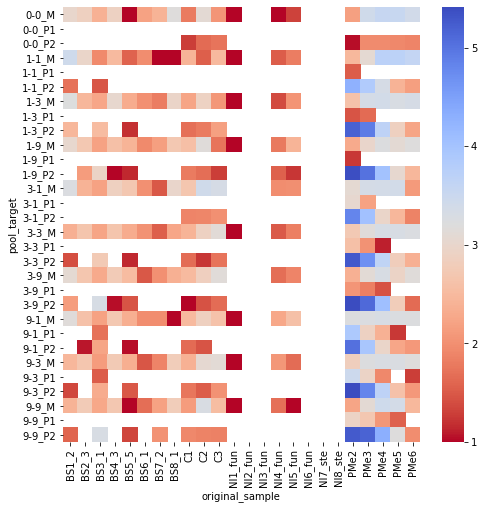

In [10]:
# heatmap of final reads
d = reads.pivot(index='pool_target', columns='original_sample', values='final').replace(0, np.nan)
d = np.log10(d)
fig, ax = plt.subplots(1,1, figsize=(8,8))
sns.heatmap(d, ax=ax, cmap='coolwarm_r', vmin=1)
ax.collections[0].colorbar.set_ticks(range(6));

In [11]:
reads['sample_type'] = 'uninfected'
reads.loc[reads.original_sample.str.startswith('BS'), 'sample_type'] = 'lab_infected'
reads.loc[reads.original_sample.str.startswith('NI'), 'sample_type'] = 'natural_infected'
reads.loc[reads.original_sample.str.startswith('PM'), 'sample_type'] = 'dilution_series'
reads.sample_type.value_counts()

natural_infected    240
lab_infected        240
dilution_series     150
uninfected           90
Name: sample_type, dtype: int64

In [12]:
reads['log_input'] = np.log10(reads['input'].replace(0,.1))

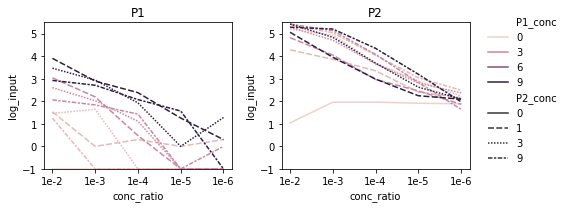

In [18]:
# dilution series
fig, axs = plt.subplots(1,2,figsize=(8, 3))
legend=None
for ax, target in zip(axs, ('P1','P2')):
    d = reads.loc[(reads.target == target) & (reads['sample_type'] == 'dilution_series')].copy()
    d['conc_ratio'] = d.original_sample.str.replace('PMe','1e-')
    g = sns.lineplot(data=d, 
             x='conc_ratio', 
             y='log_input', 
             hue='P1_conc', 
             style='P2_conc',
             ci=None, 
             ax=ax,
             legend=legend);
    legend='brief'
    ax.set_title(target)
    ax.set_ylim(-1,5.5)
    
plt.legend(bbox_to_anchor=(1.05, 1.1), loc=0, frameon=False)
plt.tight_layout();

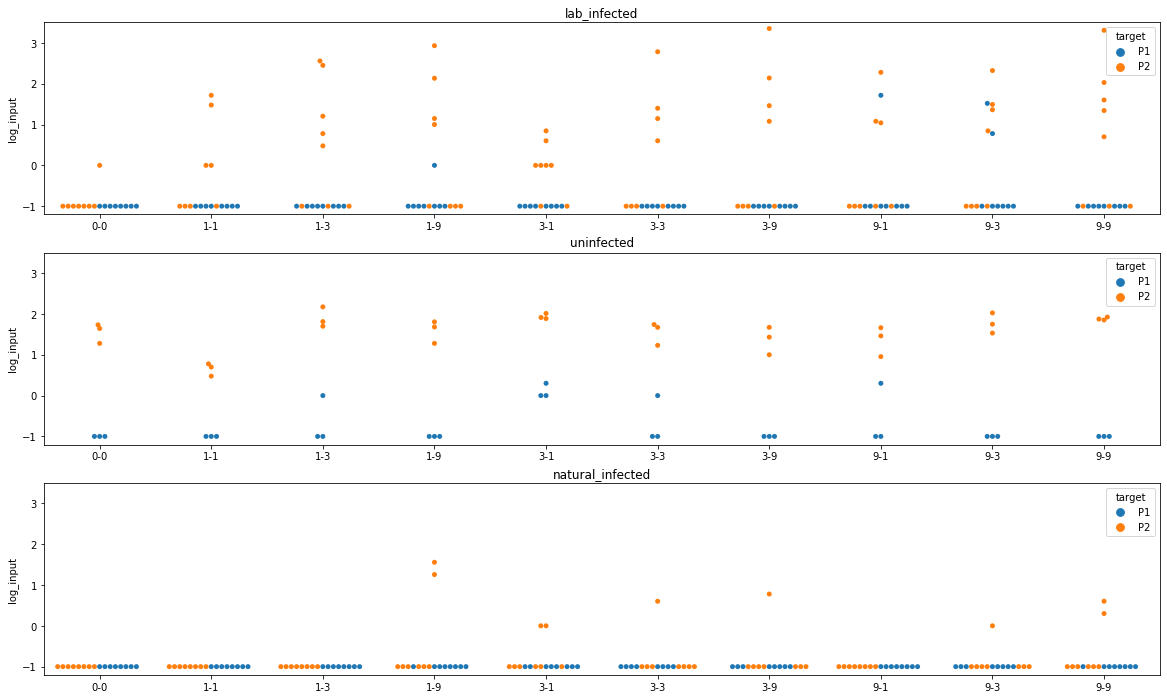

In [14]:
# read counts vs pool vs infection state 
fig, axs = plt.subplots(3,1,figsize=(20, 12))
for t, ax in zip(['lab_infected','uninfected','natural_infected'], axs):
    d = reads[(reads.target != 'M')
              & (reads.sample_type == t)]
    sns.swarmplot(data=d,
                  x='pool', 
                  y='log_input',
                  hue='target',
                  ax=ax);
    ax.set_title(t)
    ax.set_xlabel('')
    ax.set_ylim(-1.2, 3.5)